# 1. Dos resultados fundamentales


## 1.1. Ley fuerte de los grandes números

Supongamos que $X_1, \ldots, X_n$ son variables aleatorias independientes idénticamente distribuidas. Una forma de resumir su información es tomar la *media muestral*

$$
    \bar{X} = \frac{1}{n} \sum_{i=1}^n X_i.
$$

La experiencia cotidiana dice que, si observamos un realizamos medidas de un experimento muchas veces y promediamos los resultados que obtenemos, conseguimos aproximar de forma muy precisa la medida media. Esta no es sino la base misma del método científico. La afirmación rigurosa que confirma que esta intuición es cierta es el siguiente teorema.

**Teorema (Ley fuerte de los grandes números).** Sean $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas de media $\mu$ y varianza finita. Entonces, tenemos que convergen en (casi) todo punto

$$
    \bar{X} \stackrel{}{\longrightarrow} \mu
$$

**Observación.** En el caso particular de que $X_i \sim B(p)$, tenemos que $\bar{X} = \frac{\textrm{éxitos}}{totales}$, que es lo que dicta la regla de Laplace. De este modo, la ley fuerte de los grandes números dice que la estimación de la regla de Laplace es una buena aproximación de $\mathbb{E}(X_i) = p$, lo que coincide totalmente con nuestra experiencia cotidiana.

**Ejercicio.** Comprobar la ley fuerte de los grandes números con la distribución normal.

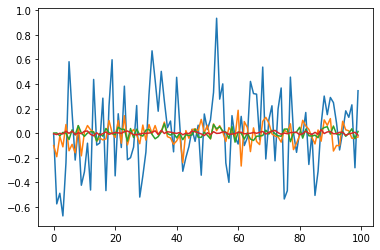

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from math import sqrt

N = 10
max_N = 100000
normalvariate = stats.norm

dibujo = []
while N < max_N:
    samples = np.zeros(100)

    for s in range(len(samples)):
        samples[s] = sum([normalvariate.rvs(0,1) for i in range(N)])/N
    
    plt.plot(range(len(samples)), samples, '-')
    N = N*10

plt.show()

## 1.2. Teorema Central del Límite

Supongamos que $X$ es una variable aleatoria de media $\mathbb{E}(X)=\mu$ y varianza $\mathbb{V}(X)=\sigma^2$. Existe una forma sencilla de *normalizar* $X$ para que tenga media $0$ y desviación típica $1$, a saber

$$
    X_0 = \frac{X - \mu}{\sigma}.
$$

En efecto, por las propiedades de media y varianza, se tiene

$$
    \mathbb{E}(X_0) = \frac{\mathbb{E}(X) - \mu}{\sigma} = 0.
$$

$$
    \mathbb{V}(X_0) = \frac{\mathbb{V}\left(X - \mu\right)}{\sigma^2} = \frac{\mathbb{V}\left(X\right) - \mathbb{V}\left(\mu\right)}{\sigma^2} = \frac{\sigma^2-0}{\sigma^2} = 1.
$$

Consideremos, en particular, $\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i$ con $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas de media $\mu$ y varianza $\sigma^2$. Entonces, tenemos que $\mathbb{E}(\bar{X}) = \mu$ y $\mathbb{V}(\bar{X}) = \frac{\sigma^2}{n}$. De este modo, la variable aleatoria $\frac{\bar{X}-\mu}{\sigma/\sqrt{n}}$ está normalizada.

**Teorema Central del Límite.** Sean $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas de media $\mu$ y varianza $\sigma^2$. Entonces, tenemos que convergen en distribución

$$
\frac{\bar{X}-\mu}{\sigma/\sqrt{n}} \stackrel{d}{\longrightarrow} N(0,1)
$$

**Observación.**
* La convergencia en distribución significa que
$$
    F_{\frac{\bar{X}-\mu}{\sigma/\sqrt{n}}}(x) \to F_{N(0,1)}(x)
$$

para (casi) todo $x \in \mathbb{R}$.
* Este resultado da la interpretación de la distribución normal: es la distribución que tiene un fenómeno si es combinación de muchos factores independientes.

**Ejercicio.** Comprobar de forma empírica el Teorema Central del Límite para la distribución de Bernouilli y para la exponencial.

In [2]:
# COMPUTA LA DISTRIBUCIÓN EMPÍRICA DE LA
# VARIABLE ALEATORIA X
def compute_empirical_dist(X, step, n_samples = 1000, rng = 3):
    steps = np.arange(-rng, rng, step)
    values = np.zeros(len(steps) + 1)

    for k in range(n_samples):
        x = X()

        index = 0
        while index < len(steps) and x > steps[index]: 
            index = index + 1
        for k in range(index, len(steps) + 1):
            values[k] = values[k] + 1

    steps = np.hstack([[-3-step], steps])

    return steps, values/n_samples

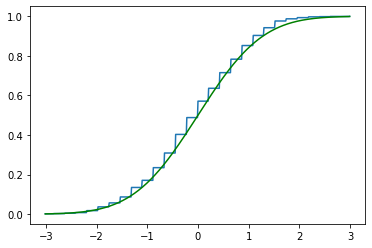

In [3]:
# MUESTREA UNA VARIABLE DE BERNOUILLI
# Y LA NORMALIZA
def benouilli_sampling_norm(p, n):
    X = 0.0
    for i in range(n):
        if random.random() < p:
            X = X + 1
    return (X/n - p)/(sqrt(p*(1-p)/n))

steps, emp_dist = compute_empirical_dist(lambda:benouilli_sampling_norm(0.3, 100), 0.01, n_samples = 1000)

#NormalDist = RealDistribution('gaussian',1)

plt.plot(steps, emp_dist)
plt.plot(steps, [normalvariate.cdf(s) for s in steps], 'g')
plt.show()

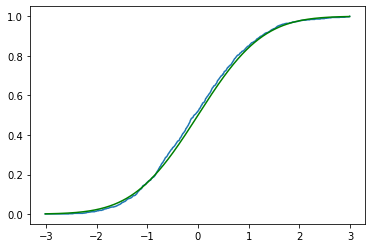

In [4]:
# MUESTREA UNA VARIABLE EXPONENCIAL
# Y LA NORMALIZA
def exponential_sampling_norm(l, n):
    X = sum(stats.expon.rvs(scale = 1/l, size = n))
    return (X/n - 1/l)/(sqrt(1/n)*1/l)

steps, emp_dist = compute_empirical_dist(lambda:exponential_sampling_norm(0.3, 100), 0.01, n_samples = 1000)

plt.plot(steps, emp_dist)
plt.plot(steps, [normalvariate.cdf(s) for s in steps], 'g')
plt.show()

# 2. Estimador de máxima verosimilitud

Supongamos que estamos estudiando un cierto fenómeno que sabemos que se distribuye con una cierta distribución $\mathcal{D}(\theta)$ de probabilidad dependiente de un parámetro $\theta \in \mathbb{R}^n$, pero no conocemos el valor exacto de $\theta$. En esta sección buscaremos un estimador $\hat{\theta}$ para el parámetro $\theta$.

**Definición.** Sea $\mathcal{D}(\theta)$ una distribución discreta con función de masa $p_{\theta}(x)$. Sean $X_1, \ldots, X_n \sim \mathcal{D}(\theta)$ variables aleatorias independientes idénticamente distribuidas. Definimos la verosimilitud de $\theta$ como

$$
    \mathcal{L}(\theta) = \prod_{i=1}^n p_{\theta}(X_i).
$$

En ese caso, definimos el *estimador de máxima verosimilitud* (MLE estimator) como

$$
    \hat{\theta} = \underset{\theta}{\mathrm{argmax}}\, \mathcal{L}(\theta).
$$

**Observación.**
* Como $p_{\theta}(x) = \mathbb{P}_\theta(X = x)$, si evaluamos las variables aleatorias $X_1, \ldots, X_n$ y obtenemos valores $x_1, \ldots, x_n$, entonces

$$
    \mathcal{L}(\theta)(x_1, \ldots, x_n) = \prod_{i=1}^n p_{\theta}(x_i) = \prod_{i=1}^n \mathbb{P}_{\theta}(X_i = x_i) = \mathbb{P}_\theta\left(X_1 = x_1, \ldots, X_n = x_n\right)
$$

Es decir, $\mathcal{L}(\theta)(x_1, \ldots, x_n)$ mide la probabilidad de que, distribuyénose las $X_i$ como $\mathcal{D}(\theta)$, podamos obtener los valores $x_1, \ldots, x_n$. Esto justifica el nombre verosimilitud.
* Si $\mathcal{D}(\theta)$ es una distribución continua con función de densidad $f_{\theta}(x)$, definimos análogamente la verosimilitud como

$$
    \mathcal{L}(\theta) = \prod_{i=1}^n f_{\theta}(X_i).
$$

De igual forma, tomamos $\hat{\theta} = \mathrm{argmax}_\theta\, \mathcal{L}(\theta)$.

* En muchas ocasiones, la función de verosimilitud es difícil de manejar y optimizar. Por ello, se toma el logaritmo de $\mathcal{L}$, llamada la *función de log-similitud*

$$
    \mathcal{l}(\theta) = \log\left(\mathcal{L}(\theta)\right) = \sum_{i=1}^n \log\left(p_{\theta}(X_i)\right).
$$

Como el logaritmo es una función estrictamente creciente, tenemos que $\mathrm{argmax}_\theta\, \mathcal{l}(\theta) = \mathrm{argmax}_\theta\, \mathcal{L}(\theta) = \hat{\theta}$, por lo que $\mathcal{l}$ también puede usarse para calcular el estimador.

* En contextos de estadística bayesiana, se suele denotar

$$
    \mathbb{P}(X_1, \ldots, X_n\,|\,\theta) = \mathcal{L}(\theta) = \prod_{i=1}^n p(X_i\,|\,\theta).
$$

Esto es especialmente relevante si asumimos que $\theta$ en sí misma es una variable aleatoria con ciertas propiedades, llamada *distribución a priori*. Por ejemplo, se puede asumir que $\theta \sim N(\mu, \sigma)$ para ciertas $\mu, \sigma$ conocidas. Este conocimiento suele provenir de la naturaleza del problema estadístico a estudiar. Supongamos que $\theta$ es una variable discreta con función de masa $p(\theta)$ (análogamente, se puede suponer que es continua y usar la función de densidad). Entonces, podemos considerar la *verosimilitud a posteriori*

$$
    \mathbb{P}(\theta \,|\,X_1, \ldots, X_n) = \frac{\mathbb{P}(X_1, \ldots, X_n\,|\,\theta)\,p(\theta)}{\mathbb{P}(X_1, \ldots, X_n)} = \frac{\mathbb{P}(X_1, \ldots, X_n\,|\,\theta)\,p(\theta)}{\sum_{\theta} \mathbb{P}(X_1, \ldots, X_n\,|\, \theta)p(\theta)} 
$$

En ese caso, se toma el *estimador Bayes* como $\hat{\theta}_{BY} = \mathrm{argmax}_\theta\, \mathbb{P}(\theta \,|\,X_1, \ldots, X_n)$. En particular, como, la cantidad $\mathbb{P}(X_1, \ldots, X_n)$ es constante en $\theta$, se puede igualmente calcular como

$$
    \hat{\theta}_{BY} = \underset{\theta}{\mathrm{argmax}}\, \mathbb{P}(X_1, \ldots, X_n\,|\,\theta)\,p(\theta).
$$

**Ejercicio.** Calcular el estimador de máxima verosimilitud para el parámetro $p$ en la distribución de Bernouilli.

*Solución.* Supongamos que, al evaluar $X_1, \ldots, X_n$, se obtienen $e$ éxito (y, por tanto $n-e$ fracasos). Entonces la verosimilitud es

$$
    \mathcal{L}(p) = \prod_{i=1}^n p_{p}(x_i) = p^{e}(1-p)^{n-e}.
$$

De este modo, la log-verosimilitud es

$$
    \mathcal{l}(p) = e \log(p) + (n-e)\log(1-p) \Rightarrow \mathcal{l}'(p) = \frac{e}{p} - \frac{n-e}{1-p} = \frac{e - pn}{p(1-p)}
$$

Así, el máximo se alcanza en cuando $\mathcal{l}'(p)=0 \Leftrightarrow e - pn = 0 \Leftrightarrow p = e/n$. De este modo, $\hat{p} = \frac{e}{n}$. ¡Otro argumento más a favor de la regla de Laplace!

**Ejercicio.** Calcular el estimador de máxima verosimilitud para el parámetro $\mu$ en la distribución normal de desviación típica conocida.

*Solución.* Si al evaluar $X_1, \ldots, X_n \sim N(\mu, \sigma)$ obtenemos valores $x_1, \ldots, x_n$, la log-verosimilitud es

$$
    \mathcal{l}(\mu) = \sum_{i=1}^n \log\left(\frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{-(x_i-\mu)^2}{2\sigma^2}}\right) = \sum_{i=1}^n \log\left(\frac{1}{\sigma \sqrt{2 \pi}}\right)  + \sum_{i=1}^n\log\left(e^{\frac{-(x_i-\mu)^2}{2\sigma^2}}\right) = -n\log\left(\sigma \sqrt{2 \pi}\right)  - \sum_{i=1}^n {\frac{(x_i-\mu)^2}{2\sigma^2}}
$$

De este modo, tenemos que $\mathcal{l}'(\mu) =  \sum_i {\frac{x_i-\mu}{\sigma^2}} = \frac{n\bar{x} - n\mu}{\sigma^2}$. Así $\mathcal{l}'(\mu) = 0 \Leftrightarrow n\bar{x} - n\mu = 0 \Leftrightarrow \mu = \bar{x}$. De este modo, el estimador de máxima verosimilitud es $\hat{\mu} = \bar{x}$.

In [5]:
n = 100000
mu = 0.6
sigma = 1.3

# CALCULAMOS EL MLE
X = normalvariate.rvs(loc = mu, scale = sigma, size = n)

mu_hat = sum(X)/n
print(mu_hat)

0.6028146294511624


**Ejercicio.** Calcular el estimador de máxima verosimilitud para el parámetro $\sigma$ en la distribución normal de media conocida.

*Solución.* Análogamente al caso anterior, la log-verosimilitud es

$$
    \mathcal{l}(\sigma) = -n\log\left(\sigma \sqrt{2 \pi}\right)  - \sum_{i=1}^n {\frac{(x_i-\mu)^2}{2\sigma^2}}
$$

Sin embargo, al derivar, ahora obtenemos

$$
    \mathcal{l}'(\sigma) = - \frac{n}{\sigma}  + \sum_{i=1}^n {\frac{(x_i-\mu)^2}{\sigma^3}} = 0 \Leftrightarrow  \sum_{i=1}^n {\frac{(x_i-\mu)^2}{\sigma^3}} =  \frac{n}{\sigma} \Leftrightarrow \sigma^2 = \frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2.
$$

De este modo, el estimador es $\hat{\sigma} = \sqrt{\frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2}$.

In [6]:
n = 100000
mu = 0.6
sigma = 1.3

# CALCULAMOS EL MLE
X = normalvariate.rvs(loc = mu, scale = sigma, size = n)

sigma_hat = sqrt(sum([(x-mu)**2 for x in X])/n)
print(sigma_hat)

1.3021839559820538


**Ejercicio.** Calcular un estimador para la correlación $\rho_{X,Y}$.

*Solución.* Se pueden hacer los cálculos en detalle, pero de lo anterior hemos visto que el estimador de la varianza es
$$
    \widehat{\sigma_X^2} = \widehat{\mathbb{E}\left((X -\mathbb{E}(X))^2\right)} = \frac{1}{n}\sum_{i=1}^n (x_i-\bar{x})^2.
$$

De este modo, es natural que un estimador para la covarianza sea
$$
    \widehat{\textrm{Cov}(X,Y)} = \widehat{\mathbb{E}\left((X -\mathbb{E}(X))(Y -\mathbb{E}(Y))\right)} =  \frac{1}{n}\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})
$$

De este modo, utilizando el estimador para la varianza anterior, obtenemos el estimador
$$
    \widehat{\rho_{X,Y}} = \widehat{\frac{\textrm{Cov}(X,Y)}{\widehat{\sigma_X} \widehat{\sigma_Y}}} =
\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}
$$

Esto es lo que se llama la **correlación de Fisher** entre las muestras de $X$ e $Y$.

# 3. Intervalos de confianza

En esta sección daremos un paso adelante en la elaboración de estimadores. Ya sabemos cómo, si queremos estimar un parámetro $\theta$, podemos usar el estimador de máxima verosimilitud, $\hat{\theta}$. Ahora bien, ¿cómo podemos cuantificar cuánto de buena es esta aproximación?

Una idea clave es usar **intervalos de confianza**. Fijemos un nivel de confianza $\beta$ (típicamente $\beta = 0.9, 0.95$ o $0.99$). Nos gustaría encontrar dos estadísticos $\hat{\theta}_1, \hat{\theta}_2$ tales que
$$
    \mathbb{P}\left(\hat{\theta}_1 < \theta < \hat{\theta}_2\right) = \beta.
$$
Eso querría significar que, **con probabilidad $\beta$**, el verdadero valor del parámetro $\theta$ se encuentra en el intervalo $\theta \in (\hat{\theta}_1, \hat{\theta}_2)$.

**Observación 1:** Típicamente, lo estadísticos del intervalo de confianza son de la forma $\hat{\theta}_1 = Q(\theta) - f_\beta(\sigma)$ y $\hat{\theta}_2 = Q(\theta) + f_\beta(\sigma)$, donde $Q(\theta)$ es una variable aleatoria *cuya distribución no depende* de $\theta$ y $f(\sigma)$ es una función de la desviación típica. Eso quiere decir que, con probabilidad $\beta$, nos estamos alejando como mucho $f_\beta(\sigma)$ del valor real del parámetro. La cantidad $Q(\theta)$ se llama la **cantidad pivotal** y, como veremos en los próximo ejemplos, es la clave para elaborar el intervalo de confianza.

**Observación 2:** La nomenclatura estándar en estadística es llamar $\beta = 1-\alpha$ y se le llama *nivel de confianza*. Así, valores típicos suelen ser $\alpha=0.1,0.05$ o $0.01$.

## 3.1 Intervalo de confianza para la media de una variable normal

Supongamos que $X_1, \ldots, X_n$ es una muestra de variables aleatorias independientes identicamente distribuidas. Además, sabemos que las $X_i$ se distribuyen como una normal con desviación típica $\sigma$ **conocida** pero media $\mu$ **desconocida**. ¿Cómo podemos calcular un intervalo de confianza?

Como $X_1, \ldots, X_n$ son normales, sabemos que el estadístico
$$
    \bar{X} = \frac{1}{n} \sum_{i=1}^n X_i
$$
es una variable aleatoria de media $\mu$ y desviación típica $\sigma/\sqrt{n}$. De este modo
$$
    Z = \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} \sim N(0,1)
$$
Recuérdese que si $Z \sim N(0,1)$, entonces existe un único $\Delta_\beta \in \mathbb{R}_{> 0}$ tal que
$$
    \mathbb{P}\left(-\Delta_\beta < Z < \Delta_\beta\right) = \beta.
$$
En particular, para $Z = \frac{\bar{X} - \mu}{\sigma/\sqrt{n}}$ se tiene
$$
    \mathbb{P}\left(-\Delta_\beta < \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} < \Delta_\beta\right) = \beta.
$$
Despejando, esto implica que
$$
    \mathbb{P}\left(\bar{X}-\Delta_\beta\frac{\sigma}{\sqrt{n}} < \mu < \bar{X}+ \Delta_\beta\frac{\sigma}{\sqrt{n}}\right) = \beta.
$$
De este modo, el intervalo de confianza para $\mu$ a nivel $\beta$ es
$$
    \left(\bar{X}-\Delta_\beta\frac{\sigma}{\sqrt{n}}, \bar{X}+ \Delta_\beta\frac{\sigma}{\sqrt{n}}\right).
$$

**Observación 1:** Nuestro intervalo de confianza tiene la forma $Q(\mu) \pm f_\beta(\sigma)$ con $f_\beta(\sigma)=\Delta_\beta\frac{\sigma}{\sqrt{n}}$ y cantidad pivotal $Q(\mu) =\bar{X}= \hat{\mu}$, el estimador de máxima verosimilitud para $\mu$.

**Observación 2:** En muchas ocasiones, $\sigma$ también será desconocida. En ese caso, podemos aproximar $\sigma$ por su estimador de máxima verosimilitud, $\hat{\sigma}$. De este modo, el intervalo sería **aproximadamente**
$$
    \left(\bar{X}-\Delta_\beta\frac{\hat{\sigma}}{\sqrt{n}}, \bar{X}+ \Delta_\beta\frac{\hat{\sigma}}{\sqrt{n}}\right)
$$
Sin embargo, debajo veremos otra forma de construir un intervalo de confianza **exacto** para $\mu$, incluso si $\sigma$ es desconocida.

**Observación 3 (Cómo calcular $\Delta_\beta$):** El valor $\Delta_\beta$ puede resultar muy misterioso, pero en realidad es fácil de calcular. Sea $Z \sim N(0,1)$ una variable aleatoria normal estándar y consideremos su función de distribución
$$
    F_{Z}(x) = \mathbb{P}(Z < x) = \int_{-\infty}^x f_Z(s)\,ds, \quad f_Z(s) = \frac{1}{\sqrt{2\pi}} e^{s^2/2}.
$$
La función $F_{Z}: \mathbb{R} \to (0,1)$ es creciente, luego tiene una función inversa $z_\gamma: (0,1) \to \mathbb{R}$ que se denomina la **función cuantil**. Por definición, $z_\gamma$ es el único número real tal que
$$
    \mathbb{P}(Z < z_\gamma) = \gamma.
$$
Esta función cuantil es estándar y suele estar implementadas en todas las librerías de cálculo estadístico (bajo el nombre *quantile*, *cdf_inv*, *ppf (point percent function)* o similar).

Relacionemos ahora $\Delta_\beta$ con $z_\gamma$. Supongamos que queremos hacer $\Delta_\beta = z_\gamma$ para cierto $0 \leq \gamma \leq 1$. Entonces ese tal $\gamma$ debe cumplir
$$
    \beta = \mathbb{P}(-z_\gamma < Z < z_\gamma) = \mathbb{P}(Z < z_\gamma)-\mathbb{P}(Z < -z_\gamma) = \mathbb{P}(Z < z_\gamma)-\mathbb{P}(Z < z_{1-\gamma}) = \gamma - (1-\gamma) = 2\gamma-1,
$$
donde hemos usado que $-z_{\gamma} = z_{1-\gamma}$ porque la función de distribución $F_Z(x)$ es simétrica respecto a $x=0$ (lo que se suele llamar ser una función par) y, por tanto, su inversa también lo es. Así, debe cumplirse $2\gamma-1 = \beta$ o, equivalentemente $\gamma = (\beta+1)/2$. En consecuencia, tenemos que $\Delta_\beta$ puede computarse a partir de la función cuantil como
$$
    \Delta_\beta = z_{(\beta+1)/2} = z_{1-\alpha/2}.
$$

**Ejercicio:** Calcular el intervalo de confianza a nivel de confianza $\beta = 0.95$ para la media en una muestra de 10000 variables aleatorias normales.

In [7]:
n = 10000
mu = 0.6
sigma = 1.3
beta = 0.95

X = normalvariate.rvs(loc = mu, scale = sigma, size = n)

Xbar = sum(X)/n
Delta_beta = normalvariate.ppf((beta+1)/2)
I_inf, I_sup = Xbar - Delta_beta*sigma/sqrt(n), Xbar + Delta_beta*sigma/sqrt(n)

print('(%s, %s)'%(I_inf, I_sup))

(0.5714169519892299, 0.6223760155872714)


In [8]:
stats.norm.interval(beta, loc=Xbar, scale=sigma/sqrt(n))

(0.5714169519892299, 0.6223760155872714)

**Ejercicio:** Calcular el cuantil 0.975 de una normal estandar. Dibujar la función cuantil de la normal.

El cuantil 0.975 de una normal estandar es: 1.959963984540054


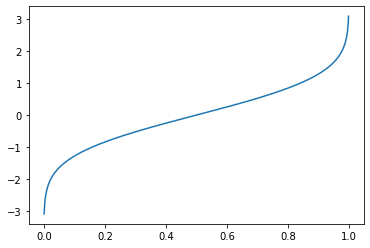

In [9]:
print('El cuantil 0.975 de una normal estandar es: ' + str(stats.norm.ppf(0.975)))

alpha = np.linspace(0, 1, 1000)
quant = stats.norm.ppf(alpha)

plt.plot(alpha, quant)
plt.show()

## 3.2 Intervalo de confianza para la media de una variable Benoulli

Si tenemos una muestra $X_1, \ldots, X_n$ de variables aleatorias independientes e idénticamente distribuidas, pero cuya distribución no es normal, aún podemos usar el mismo argumento para encontrar un intervalo de confianza aproximado. En efecto, por el Teorema Central del Límite, tenemos que
$$
    \frac{\bar{X} - \mu}{\sigma/\sqrt{n}}
$$
se distribuye, aproximadamente, como una $N(0,1)$ para $n$ suficientemente grande. De este modo, tenemos que
$$
    \mathbb{P}\left(-z_{(\beta+1)/2} < \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} < z_{(\beta+1)/2}\right) \approx \beta
$$
para $n$ grande.

Usando esta estimación, podemos calcular intervalos de confianza para distintas distribuciones. Por ejemplo, si las $X_i$ se distribuyen como variables aleatorias de Benoulli $B(p)$ para $0 \leq p \leq 1$ desconocido, entonces sabemos que $\mu = p$ y $\sigma = \sqrt{p(1-p)}$ y, por tanto, el intervalo de arriba dice
$$
    \mathbb{P}\left(-z_{(\beta+1)/2} < \frac{\bar{X} - p}{\sqrt{p(1-p)}/\sqrt{n}} < z_{(\beta+1)/2}\right) \approx \beta
$$
Esto nos proporciona una ecuación cuadrática en $p$ que podemos resolver. Si queremos obtener una fórmula cerrada, podemos sustituir las $p$ del denominador por su estimador de máxima verosimilitud $\hat{p} = \bar{X}$ y queda
$$
    \mathbb{P}\left(-z_{(\beta+1)/2} < \frac{\bar{X} - p}{\sqrt{\bar{X}(1-\bar{X})}/\sqrt{n}} < z_{(\beta+1)/2}\right) \approx \beta.
$$
De este modo, si despejamos
$$
    \mathbb{P}\left(\bar{X} - z_{(\beta+1)/2}\sqrt{\frac{\bar{X}(1-\bar{X})}{n}} < p < \bar{X} + z_{(\beta+1)/2}\sqrt{\frac{\bar{X}(1-\bar{X})}{n}}\right) \approx \beta,
$$
lo que nos da el intervalo de confianza a nivel $\beta$ para $p$

$$
    \left(\bar{X} - z_{(\beta+1)/2}\sqrt{\frac{\bar{X}(1-\bar{X})}{n}}, \bar{X} + z_{(\beta+1)/2}\sqrt{\frac{\bar{X}(1-\bar{X})}{n}}\right)
$$

**Ejercicio:** Calcular el intervalo de confianza a nivel de confianza $\beta = 0.95$ para la media en una muestra de 10000 variables aleatorias de tipo Bernoulli.

In [10]:
n = 10000
p = 0.7
beta = 0.95

X = [np.random.binomial(1, p) for i in range(n)]

Xbar = sum(X)/n
Delta_beta = normalvariate.ppf((beta+1)/2)
I_inf, I_sup = Xbar - Delta_beta*sqrt(Xbar*(1-Xbar)/n), Xbar + Delta_beta*sqrt(Xbar*(1-Xbar)/n)

print('(%s, %s)'%(I_inf, I_sup))

(0.6975749999564326, 0.7154250000435675)


## 3.3. Intervalo de confianza $\chi^2$

Este es el primer caso en el que veremos realmente la utilidad de la cantidad pivotal. Supongamos que tenemos $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas con distribución normal $N(\mu, \sigma)$ y, ahora, queremos estimar **varianza** $\sigma^2$ sin saber $\mu$.

En base al estimador insesgado de máxima verosimilitud para $\sigma^2$ podemos considerar el estadístico
$$
    \hat{s}^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2,
$$
que es un estimador para la varianza $\sigma^2$. Obsérvese que podemos escribir
$$
    \frac{(n-1)\hat{s}^2}{\sigma^2} = \sum_{i=1}^n \frac{(X_i - \bar{X})^2}{\sigma^2} = \sum_{i=1}^n \frac{(X_i - \mu)^2}{\sigma^2} - n \frac{(\bar{X}-\mu)^2}{\sigma^2}.
$$
Esto es una suma $\frac{(n-1)\hat{s}^2}{\sigma^2} = \sum_{i=1}^n Z_i^2 - \tilde Z^2$, con $Z_i = \frac{(X_i - \bar{X})}{\sigma}$ y $\tilde Z^2 = n \frac{(\bar{X}-\mu)^2}{\sigma^2}$ variables aleatorias independientes **con distribución $Z_i \sim N(0,1)$**. Por definición (véase el tema de Probabilidad) una variable aleatoria de esta forma se llama una **distribución $\chi^2$ con $n-1$ grados de libertad** y se denota $\chi^2(n-1)$.

De este modo, tomemos como $\chi^2_{n-1,\alpha}$ el $\alpha$-cuantil de la distibución de $\chi^2(n-1)$, es decir, el único número real positivo tal que, para $Y \sim \chi^2(n-1)$
$$
    \mathbb{P}\left(Y < \chi^2_{n-1,\alpha}\right) = \alpha.
$$
De este modo, para un intervalo tenemos que
$$
\mathbb{P}\left(\chi^2_{n-1,\alpha/2} < Y < \chi^2_{n-1,1-\alpha/2}\right) = \mathbb{P}\left(Y < \chi^2_{n-1,1-\alpha/2}\right) - \mathbb{P}\left(Y<\chi^2_{n-1,\alpha/2}\right) = 1-\alpha/2-\alpha/2 = 1-\alpha.
$$
Así, tomando $Y = \frac{(n-1)\hat{s}^2}{\sigma^2}$, tenemos que
$$
    \mathbb{P}\left(\chi^2_{n-1,\alpha/2} < \frac{(n-1)\hat{s}^2}{\sigma^2} < \chi^2_{n-1,1-\alpha/2}\right) = 1-\alpha.
$$
Lo que, despejando, nos da
$$
    \mathbb{P}\left(\frac{(n-1)\hat{s}^2}{\chi^2_{n-1,1-\alpha/2}} < \sigma^2 < \frac{(n-1)\hat{s}^2}{\chi^2_{n-1,\alpha/2}}\right) = 1-\alpha.
$$
De este modo, el intervalo de confianza para $\sigma^2$ con nivel de confianza $\beta = 1-\alpha$ es
$$
    \left(\frac{(n-1)\hat{s}^2}{\chi^2_{n-1,1-\alpha/2}}, \frac{(n-1)\hat{s}^2}{\chi^2_{n-1,\alpha/2}}\right)
$$

**Observación:** Una idea similar usaremos para construir el famoso **test $\chi^2$** en la Sección 4.

In [11]:
n = 10000
mu = 0.6
sigma = 1.3
beta = 0.95

X = normalvariate.rvs(loc = mu, scale = sigma, size = n)

shat = stats.tstd(X) # Observacion: std computa la version insesgada hat(s)

alpha = 1-beta
ChiSqDist = stats.chi2
Delta1 = ChiSqDist.ppf(1-alpha/2, df = n-1)
Delta2 = ChiSqDist.ppf(alpha/2, df = n-1)
I_inf, I_sup = (n-1)*shat/Delta1, (n-1)*shat/Delta2

print('(%s, %s)'%(I_inf, I_sup))

(1.2788172557382314, 1.3517192223537482)


## 3.4. Intervalo de confianza $t$ de Student

En este caso daremos un paso más adelante y estimaremos la media de una muestra normal **sin conocer la varianza** de forma **exacta**. Para ello, sea $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas con distribución normal $N(\mu, \sigma)$, con $\mu$ y $\sigma$ **desconocidas**.

Sea $Z \sim N(0,1)$ y $V \sim \chi^2(\nu)$ independientes. Recordemos que la distribución $t$ de Student con $\nu$ grados de libertad, denotada $t(\nu)$, es la distribución de
$$
    T = \frac{Z}{\sqrt{V/\nu}}.
$$
En nuestro caso, por la Sección 3.4, sabemos que podemos tomar $V = \frac{(n-1)\hat{s}^2}{\sigma^2} \sim \chi^2(n-1)$. Además, como siempre, $Z = \frac{X-\mu}{\sigma/\sqrt{n}} \sim N(0,1)$ y se puede comprobar que $V$ y $Z$ son independientes (este hecho se llama el lema de Fisher-Cochran). De este modo, tenemos que
$$
    T = \frac{\frac{\bar{X}-\mu}{\sigma/\sqrt{n}}}{\sqrt{\frac{(n-1)\hat{s}^2}{\sigma^2(n-1)}}} = \frac{\frac{\bar{X}-\mu}{\sigma/\sqrt{n}}}{\frac{\hat{s}}{\sigma}} = \frac{\bar{X}-\mu}{\hat{s}/\sqrt{n}} \sim t(n-1).
$$
En consecuencia, si tomamos $\Delta^t_\beta$ tal que
$$
    \mathbb{P}\left(-\Delta^t_\beta < T < \Delta^t_\beta\right) = \beta,
$$
entonces tenemos que
$$
    \mathbb{P}\left(-\Delta^t_\beta < \frac{\bar{X}-\mu}{\hat{s}/\sqrt{n}} < \Delta^t_\beta\right) = \beta.
$$
Como siempre, esto nos proporciona un intervalo de confianza despejando para $\mu$
$$
    \mathbb{P}\left(\bar{X}-\Delta^t_\beta\frac{\hat{s}}{\sqrt{n}} < \mu < \bar{X} + \Delta^t_\beta \frac{\hat{s}}{\sqrt{n}}\right) = \beta.
$$
Con lo que el intervalo de confianza a nivel $\beta$ para $\mu$ es
$$
    \left(\bar{X}-\Delta^t_\beta\frac{\hat{s}}{\sqrt{n}}, \bar{X} + \Delta^t_\beta \frac{\hat{s}}{\sqrt{n}}\right).
$$

**Observación 1:** El valor $\Delta^t_\beta$ puede ser calculado con un argumento similar al de la Sección 3.1. De este modo, si $t_{n-1, \gamma}$ es el $\gamma$-cuantil de la distribución $t$ de Student con $n-1$ grados de libertad, tenemos que
$$
    \Delta_\beta^t = t_{n-1, (\beta + 1)/2} = t_{n-1, 1-\alpha/2}.
$$

**Ejercicio:** Calcular el intervalo de confianza a nivel de confianza $\beta = 0.95$ para la media en una muestra de 100 variables aleatorias normales.

In [12]:
n = 1000
mu = 0.6
sigma = 1.3
beta = 0.95

X = normalvariate.rvs(loc = mu, scale = sigma, size = n)

Xbar = sum(X)/n
shat = stats.tstd(X)

# Intervalo de confianza exacto con la t de Student
tStudentDist = stats.t
Delta_beta_t = tStudentDist.ppf((beta+1)/2, df = n-1)
I_inf_t, I_sup_t = Xbar - Delta_beta_t*shat/sqrt(n), Xbar + Delta_beta_t*shat/sqrt(n)

# Intervalo de confianza aproximado con la normal
Delta_beta_norm = normalvariate.ppf((beta+1)/2)
I_inf_norm, I_sup_norm = Xbar - Delta_beta_norm*shat/sqrt(n), Xbar + Delta_beta_norm*shat/sqrt(n)

print('Intervalo t Student exacto: (%s, %s)'%(I_inf_t, I_sup_t))
print('Intervalo normal aproximado: (%s, %s)'%(I_inf_norm, I_sup_norm))

Intervalo t Student exacto: (0.483503305879028, 0.6447535141675867)
Intervalo normal aproximado: (0.4836009872977513, 0.6446558327488634)


**Observación 2:** Como es lógico, el intervalo de confianza obtenido en la Sección 3.4 se parece enormemente al sugerido en la Observación 2 de la Sección 3.1. La ventaja es que, en este caso, el intervalo es **exacto**, en lugar del anterior que solo era aproximado y, por tanto, proporciona mejores resultados.

De hecho, la función de densidad de la $t$ de Student es muy similar a la de la normal estándar. La diferencia más notable es que la densidad de la $t$ de Student tiene colas 'más pesadas', que se van aproximando a las colas de la normal según los grados de libertad crecen. Esto es esperable porque, en el límite cuando $n \to \infty$, en intervalo de confianza aproximado converge al exacto.

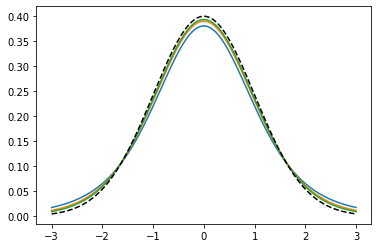

In [13]:
x = np.linspace(-3, 3, 1000)

for i in range(5, 20, 5):
    y = tStudentDist.pdf(x, df = i)
    plt.plot(x,y)

plt.plot(x, normalvariate.pdf(x), '--k')
    
plt.show()

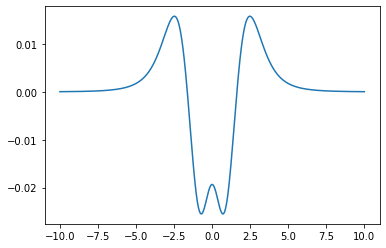

In [14]:
# Dibujo de la diferencia de ambas funciones de densidad

x = np.linspace(-10,10,1000)
plt.plot(x, tStudentDist.pdf(x, df = 5) - normalvariate.pdf(x))
plt.show()

## 3.4. Intervalo de confianza para la correlación

Una cantidad importante a estimar es la **correlación**. Supongamos que $X$ e $Y$ son dos variables aleatorias, no necesariamente independientes con desviaciones típicas $\sigma_X$ y $\sigma_Y$, respectivamente. Recuérdese que la correlación de Pearson entre $X$ e $Y$ es
$$
    \rho = \frac{\textrm{Cov}(X,Y)}{\sigma_X \sigma_Y} = \frac{\mathbb{E}\left((X-\mathbb{E}(X))(Y-\mathbb{E}(Y))\right)}{\sigma_X \sigma_Y}.
$$

Supongamos ahora que tenemos muestras $X_1, \ldots, X_n$ e $Y_1, \ldots, Y_n$ de $X$ e $Y$. Mediante ellas, podemos estimar la correlación como
$$
    \hat{\rho} = \frac{\sum ^n _{i=1}(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum^n _{i=1}(X_i - \bar{X})^2} \sqrt{\sum ^n _{i=1}(Y_i - \bar{Y})^2}}
$$

De este modo, un problema interesante sería elaborar intervalos de confianza para el estimador $\hat{\rho}$. No obstante, $\hat{\rho}$ está muy lejos de ser normal pues, por ejemplo, está restringido a vivir en el intervalo $[-1,1]$. Para solucionarlo, consideremos la función
$$
    \textrm{atanh}: (-1,1) \to \mathbb{R}
$$

**Observación:** Dependiendo de la librería, $\textrm{atanh}$ también se puede llamar $\textrm{arctanh}$.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.


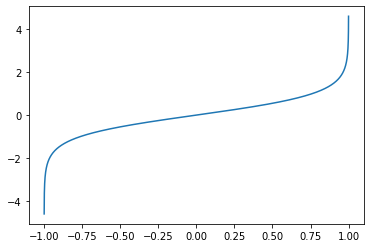

In [15]:
import math 

x = np.linspace(-1, 1, 10000)
y = np.arctanh(x)

plt.plot(x,y)
plt.axis('tight')
plt.show()

**Teorema** (Fisher). Si $\hat{\rho}_{X,Y}$ es el estimador de la correlación de Fisher, entonces,
$$
    R = \textrm{atanh}(\hat{\rho})
$$
es aproximadamente una variable aleatoria normal de media $\textrm{atanh}(\rho)$ y desviación típica $\frac{1}{\sqrt{n-3}}$.

Utilizando este resultado, es posible calcular intervalos de confianza para la correlación. Como $\left(R-\textrm{atanh}(\rho)\right)\sqrt{n-3} \sim N(0,1)$, entonces existe un único $\Delta_\beta \in \mathbb{R}_{> 0}$ tal que
$$
    \mathbb{P}\left(-\Delta_\beta < \left(R-\textrm{atanh}(\rho)\right)\sqrt{n-3} < \Delta_\beta\right) = \beta \Leftrightarrow \mathbb{P}\left(R-\frac{\Delta_\beta}{\sqrt{n-3}} <  \textrm{atanh}(\rho) < R + \frac{\Delta_\beta}{\sqrt{n-3}}\right) = \beta.
$$
Ahora, obsérvese que, si para pasar de $\hat{\rho}$ a $R$ hemos usado la función $\textrm{atanh}$, podemos deshacer el camino mediante la función $\textrm{tanh}. En particular, esto implica que

$$
     \mathbb{P}\left(\textrm{tanh}\left(R-\frac{\Delta_\beta}{\sqrt{n-3}}\right) <  \rho < \textrm{tanh}\left(R + \frac{\Delta_\beta}{\sqrt{n-3}}\right)\right) = \beta
$$

De este modo, utilizando que $\Delta_\beta = z_{1-\alpha/2}$ el intervalo de confianza para $\hat{\rho}$ a nivel $1-\alpha$ es
$$
    \left(\textrm{tanh}\left(R-\frac{z_{1-\alpha/2}}{\sqrt{n-3}}\right), \textrm{tanh}\left(R + \frac{z_{1-\alpha/2}}{\sqrt{n-3}}\right)\right)
$$

# 4. Test de hipótesis

Los test de hipótesis son uno de los descubrimientos más importantes del siglo XX. Tal es su importancia que las ciencias experimentales basan profundamente su conocimiento en esta herramienta estadística.

La clave de los test de hipótesis es que permiten decidir de una forma razonada si existe evidencias estadísticas suficientes a favor de una hipótesis o no. Actúan así como jueces, que permiten aceptar o rechazar hipótesis en base a la evidencia empírica.

Supongamos que queremos contrastar la validez de una hipótesis. Esta hipótesis se denomina de **hipótesis nula** y se denota por $H_0$. En contraposición, la negación de la hipótesis se denomina la **hipótesis alternativa** y se denota por $H_1$. Para ello, realizamos una serie de experimentos $X_1, \ldots, X_n$ y computamos un cierto estadístico $Q = Q(X_1, \ldots, X_n)$. Usando el valor $Q$ podremos decidir si existe evidencia estadística suficiente a favor de $H_0$ (en cuyo caso se acepta $H_0$) o no (en cuyo caso se acepta $H_1$).

A grandes rasgos, el proceso general de un test de hipótesis es el siguiente. En primer lugar, se fija un valor $0 \leq \alpha \leq 1$ (típicamente $\alpha = 0.1, 0.05$ o $0.01$), llamado el nivel de significación. Si la hipótesis nula $H_0$ es cierta, eso implicará que la distribución del estadístico $Q$ es conocida. De este modo, podremos dar un intervalo de confianza para $Q$ de la forma
$$
    \mathbb{P}\left(Q \in I_\alpha\right) = 1- \alpha,
$$
para cierto conjunto $I_\alpha$ independiente de la muestra (pero dependientes de $\alpha$). Típicamente $I_\alpha$ será un intervalo de confianza.

Esto se interpreta de la siguiente forma: si $H_0$ es cierta, entonces con probabilidad $1-\alpha$ el estadístico $Q = Q(X_1, \ldots, X_n)$ cumplirá $Q \in I_\alpha$. Dicho de otro modo: con probabilidad $\alpha$ se cumple que $Q \not\in I_\alpha$. Ese será precisamente nuestro control.
- **Aceptaremos $H_0$** si $Q \in I_\alpha$ y diremos que *no hay evidencia estadística suficiente en contra de $H_0$*.
- **Rechazaremos $H_0$** si $Q \not\in I_\alpha$. En ese caso, aceptaremos la hipótesis alternativa $H_1$ y diremos que *hay evidencia estadística suficiente en contra de $H_0$*

**Observación 1:** En algunas tablas de test de hipótesis, se proporciona el conjunto complementario a $I_\alpha$, denotado $R_\alpha$ y llamada la **región de rechazo**. Así, se acepta $H_0$ si $Q \not\in R_\alpha$ y se rechaza si $Q \in R_\alpha$.

**Observación 2:** El papel de las hipótesis $H_0$ y $H_1$ es asimétrico. $H_0$ representa el *statu quo*, es decir, la hipótesis que estamos dispuesto a aceptar si no hay evidencias en su contra (es como la presunción de inocencia en un juicio). Por contra, para aceptar $H_1$ es necesario que haya una gran evidencia en contra de $H_0$ (al igual que es necesario una gran evidencia para condenar a un acusado en un juicio).

**Observación 3:** En la nomenclatura de la literatura sobre contraste de hipótesis (especialmente en la basada en epidemiología) se introducen los llamados errores de tipo I y II. El error de tipo I se produce cuando, aún siendo $H_0$ cierta, cometemos el error de rechazarla (esto es, obtenemos un falso negativo). Por contra, los errores de tipo II se producen cuando se acepta erróneamente $H_0$ aún siendo falsa (esto es, obtenemos un falso positivo). Por diseño, los test de hipótesis fijan la probabilidad de tipo I admisible (esto es, $\alpha$). Pero lo más óptimo es buscar test que, a nivel de significación $\alpha$ fijado, tengan la menor probabilidad de cometer un error de tipo II.

## 4.1. Test de hipótesis sobre una muestra

En estos test, se realizan $n$ muestreos independientes identicamente distribuidos $X_1, \ldots, X_n$ y queremos evaluar si una cierta hipótesis sobre la distribución subyacente (típicamente, sobre la media) es correcta o no.

### 4.1.1. Test sobre el valor de la media

Supongamos que $X_1, \ldots, X_n$ de distribuyen como una normal de media $\mu$ y varianza desconocidas. En este test, vamos a evaluar si la media es un cierto valor $\mu_0 \in \mathbb{R}$ o no. De este modo, tenemos
$$
    H_0: \mu = \mu_0, \quad H_1: \mu \neq \mu_0.
$$
Para ello, supongamos que $H_0$ es cierta. En ese caso $\mu_0$ es la esperanza de las variables $X_i$ y, por tanto, por la Sección 3.4
$$
\frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} \sim t(n-1).
$$
De manera que, si fijamos un nivel de significación $\alpha$, tenemos que
$$
    \mathbb{P}\left(-t_{n-1, 1-\alpha/2} < \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha/2}\right) = 1-\alpha.
$$
Así, tomaremos como estadístico de contraste $Q = \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}}$ y para $I_\alpha$ el intervalo $I_\alpha = (-t_{n-1, 1-\alpha/2}, t_{n-1, 1-\alpha/2}) \subseteq \mathbb{R}$. De este modo, el criterio de este test es:
- Aceptamos $H_0$ si $Q \in I_\alpha$, esto es, si
$$
    -t_{n-1, 1-\alpha/2} < \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha/2}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si $Q \not\in I_\alpha$, esto es, si
$$
    \left|\frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}}\right| \geq t_{n-1, 1-\alpha/2}.
$$

**Ejercicio 1:** Se analiza un envı́o de botellas de aceite que se ha envasado con un mecanismo del que se afirma que, en promedio, rellena las botellas con 100 cl. de aceite. Examinada una muestra de 5 botellas se obtienen las medidas 95 cl., 101 cl., 96 cl., 93 cl. y 92 cl. Supongamos que el contenido de aceite (en cl.) en una botella, sigue una distribución normal. ¿Existe evidencia empı́rica suficiente a nivel $\alpha = 0.05$ para afirmar que el contenido medio de las botellas no es 100 cl.? ¿Y a nivel $\alpha = 0.01$?

In [16]:
X = [95,101,96,93,92]
n = len(X)
Xbar = np.mean(X)
shat = stats.tstd(X)

# A nivel alpha = 0.05
mu_0 = 100 # La hipotesis nula es mu = mu_0 = 100
alpha = 0.05
Q = (Xbar-mu_0)/(shat/sqrt(n))
threshold = tStudentDist.ppf(1-alpha/2, df = n-1)

print('Nivel alpha = %s'%alpha)
print('Q = %s'%Q)
print('t = %s'%threshold)

if abs(Q) >= threshold:
    print('H_0 rechazada: existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel %s'%alpha)
else:
    print('H_0 aceptada: no existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel %s'%alpha)

# A nivel alpha = 0.01
alpha = 0.01
threshold = tStudentDist.ppf(1-alpha/2, df = n-1)
    
print('Nivel alpha = %s'%alpha)
print('Q = %s'%Q)
print('t = %s'%threshold)

if abs(Q) >= threshold:
    print('H_0 rechazada: existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel %s'%alpha)
else:
    print('H_0 aceptada: no existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel %s'%alpha)    

Nivel alpha = 0.05
Q = -2.9328528800913527
t = 2.7764451051977987
H_0 rechazada: existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel 0.05
Nivel alpha = 0.01
Q = -2.9328528800913527
t = 4.604094871415897
H_0 aceptada: no existe evidencia estadistica suficiente en contra de la hipotesis nula a nivel 0.01


**Observación 1:** El anterior ejercicio muestra un fenómeno general en los test de hipótesis: *cuanto más pequeño es $\alpha$, más conservador es el test y, por tanto, más fácil es aceptar $H_0$*. De este modo, una hipótesis nula que es rechazada a nivel $\alpha$, podría ser aceptada a nivel $\alpha' < \alpha$. Para tener en cuenta este factor, generalmente en los test de hipótesis se utiliza el concepto de **$p$-valor**. Por definición, el $p$-valor es el nivel de significación $\alpha$ más pequeño (formalmente, el ínfimo) para el que $H_0$ es rechazada. De este modo, *cuanto más pequeño es el $p$-valor, más evidencia estadística en contra de $H_0$ (equivalentemente, a favor de $H_1$) existe*.

**Ejercicio 2:** Calcular el $p$-valor del contraste de hipótesis anterior.

In [17]:
p_value = 0.1

threshold = tStudentDist.ppf(1-p_value/2, df = n-1)
while abs(Q) >= threshold:
    p_value -= 0.0001
    threshold = tStudentDist.ppf(1-p_value/2, df = n-1)

print('p-valor = %s'%p_value)

p-valor = 0.04259999999999836


In [18]:
# El p-valor también se pude obtener usando la funcion ttest de stats de Python

stats.ttest_1samp(X, 100)

Ttest_1sampResult(statistic=-2.9328528800913523, pvalue=0.042692152758449495)

**Observación 2:** Estrictamente, el test anterior únicamente es válido cuando las variables aleatorias $X_1, \ldots, X_n$ son normales. Sin embargo, si son variables aleatorias independientes y $n$ es grande, por el Teorema Central del Límite, $\bar{X}$ es **aproximadamente normal**. Por este motivo, cuando $n$ es grande, también suele usarse este test de hipótesis para contrastar la media, incluso si la muestra no es normal.

### 4.1.2. Test de estimación de la media (cola derecha)

De igual forma que en el test anterior hemos evaluado si la media es un determinado valor, también podemos realizar test de hipótesis para evaluar si la media es mayor que un cierto valor dado $\mu_0$. De este modo, las hipótesis serían 
$$
    H_0: \mu \leq \mu_0, \quad H_1: \mu > \mu_0.
$$
Igualmente que antes, si $H_0$ es cierta, entonces
$$
    1-\alpha = \mathbb{P}\left(\frac{\bar{X}-\mu}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha}\right) = \mathbb{P}\left(\frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} + \frac{\mu_0-\mu}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha}\right) \leq \mathbb{P}\left(\frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha}\right)
$$
$$
    \Rightarrow \mathbb{P}\left(\frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} \geq t_{n-1, 1-\alpha}\right) \leq \alpha.
$$
Así, tenemos controlada la probabilidad de error de tipo I por $\alpha$. De este modo tomaremos como estadístico de contraste $Q = \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}}$ y para $I_\alpha$ el intervalo $I_\alpha = (-\infty, t_{n-1, 1-\alpha}) \subseteq \mathbb{R}$. De este modo, el criterio de este test es:
- Aceptamos $H_0$ si $Q \in I_\alpha$, esto es, si
$$
    \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} < t_{n-1, 1-\alpha}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si $Q \not\in I_\alpha$, esto es, si
$$
    \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} \geq t_{n-1, 1-\alpha}.
$$

**Observación:** Análogo resultado tenemos para la desigualdad contraria. De este modo, para el test
$$
    H_0: \mu \geq \mu_0, \quad H_1: \mu < \mu_0.
$$
el criterio es:
- Aceptamos $H_0$ si
$$
    \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} > t_{n-1, \alpha}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si $Q \not\in I_\alpha$, esto es, si
$$
    \frac{\bar{X}-\mu_0}{\hat{s}/\sqrt{n}} \leq t_{n-1, \alpha}.
$$

**Ejercicio 3:** Repetir el Ejercicio pero ahora para evaluar si, en media, el sistema de envasado proporciona al menos 100 cl. Calcular el $p$-valor.

 ### 4.1.3. Test $\chi^2$ de bondad de ajuste
 
 Supongamos que tenemos $X_1, \ldots, X_n$ variables aleatorias independientes idénticamente distribuidas con distribución categórica subyacence con un número de clases conocido. De este modo, $X_i \sim Cat(p_1, \ldots, p_k)$ donde $k$ es conocido pero las probabilidades $\mathbf{p} = (p_1, \ldots, p_k)$ no lo son. 
 
El test $\chi^2$, también llamado test de bondad de ajuste, permite evaluar si el valor de las probabilidades categóricas es correcto. De este modo, fijado $\mathbf{p}^0 = (p_1^0, \ldots, p_k^0)$ con $\sum_i p_i^0 = 1$, las hipótesis son
$$
    H_0: \mathbf{p} = \mathbf{p}^0, \quad H_1: \mathbf{p} \neq \mathbf{p}^0.
$$
Para realizar este test, veamos $Cat(\mathbf{p}) = Mult(1, k, \mathbf{p})$ como una distribución multinomial con $k$ clases y un único intento. De este modo, $X_i$ es un vector aleatorio $X_i = (X_i^1, \ldots, X_i^k)$ donde, en cada experimento, únicamente una de las $X_i^j$ es $1$ y el resto vale $0$, indicando así que en la $i$-ésima muestra se obtuvo la $j$-ésima clase. Así, cada variable $X^j_{i}$ es una variable aleatoria de tipo Bernoulli con probabilidad $p_j$.

Si $H_0$ es cierta, tenemos que las variables aleatorias $\bar{X^j} = \frac{1}{n} \sum_i X_i^j$ tienen esperanza $p_j^0$ y varianza $p_j^0(1-p_j^0)$. De este modo, por el Teorema Central del Límite, las variables aleatorias 
$$
     Z^j = \frac{\bar{X^j} - p_j^0}{\sqrt{np_j^0}}
$$
convergen en distribución a una normal $N(0, \sqrt{1-p_j^0})$. Ahora bien, estas variables aleatorias **no son independientes** (por ejemplo, porque $\sum_i \bar{X^i} = 1$). Si compensamos las covarianzas de estas variables aleatorias, se puede probar que, análogamente a la Sección 3.3, tenemos que el estadístico
$$
    Q = n \sum_{j=1}^k (Z^j)^2 \stackrel{d}{\longrightarrow} \chi^2(k-1).
$$
**Observación 1:** La demostración precisa de este resultado require un poco de trabajo y se denomina el Teorema de Pearson.

**Observación 2:** En este caso, los grados de libertad de la distribución $\chi^2$ **no dependen del tamaño de la muestra** sino del número de características a testear, que generalmente es pequeño. Por este motivo, en este caso la diferencia entre las distribuciones $\chi^2$ y normal es crucial.

Calculando explícitamente el estadístico $Q$, tenemos que es
$$
    Q = n \sum_{j=1}^k \left(\frac{\bar{X^j} - p_j^0}{\sqrt{np_j^0}}\right)^2 = \sum_{j=1}^k \frac{\left(\bar{X^j} - p_j^0\right)^2}{np_j^0},
$$
que se denomina el estadístico de Pearson (o a veces el estadístico $\chi^2$). En consecuencia, como $Q$ es aproximadamente $\chi^2(k-1)$ para $n$ grande, tenemos que
$$
    \mathbb{P}\left(\chi^2_{k-1,\alpha/2} < Q < \chi^2_{k-1,1-\alpha/2}\right) \approx 1-\alpha.
$$
En consecuencia, totamos $I_\alpha = \left(\chi^2_{k-1,\alpha/2},\chi^2_{k-1,1-\alpha/2}\right)$ y el criterio de este test es:
- Aceptamos $H_0$ si $Q \in I_\alpha$, esto es, si
$$
   \chi^2_{k-1,\alpha/2} < \sum_{j=1}^k \frac{\left(\bar{X^j} - p_j^0\right)^2}{np_j^0} < \chi^2_{k-1,1-\alpha/2}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si $Q \not\in I_\alpha$, esto es, si
$$
\sum_{j=1}^k \frac{\left(\bar{X^j} - p_j^0\right)^2}{np_j^0} \geq \chi^2_{k-1,1-\alpha/2} \quad \textrm{ó}\quad \sum_{j=1}^k \frac{\left(\bar{X^j} - p_j^0\right)^2}{np_j^0} \leq \chi^2_{k-1,\alpha/2}.
$$

**Observación 3:** Este tipo de test en los que el error de tipo I solo se controla asintóticamente suelen llamarse tests asintóticos.

**Ejercicio.** En el famoso experimento de Mendel se cruzaron plantas de guisantes con fenotipo liso-amarillo con otras en las que los guisantes tenı́an fenotipo rugoso-verde. En la segunda generación se podı́an observar cuatro fenotipos (liso-amarillo, rugoso-amarillo, liso-verde, rugoso-verde) cuyas respectivas probabilidades, según la teorı́a de la herencia mendeliana, debı́an ser
$$
p_1^0 = \frac{9}{16}, \quad p_2^0 = \frac{3}{16}, \quad p_3^0 = \frac{3}{16}, \quad p_1^0 = \frac{1}{16}.
$$
Mendel observó $556$ guisantes en la segunda generación del experimento y obtuvo $315$ guisantes con el fenotivo liso-amarillo, $101$ con el fenotivo rugoso-amarillo, $108$ con el fenotivo liso-verde y $32$ con el fenotivo rugoso-verde. Calcular el $p$-valor de un test de bondad de ajuste para decidir si el experimento de Mendel respalda sus hipótesis.

In [19]:
n = 556
stats.chisquare([315, 101, 108, 32], f_exp=[9/16*n, 3/16*n, 3/16*n, 1/16*n])

# Observacion: La funcion chisquare espera frecuencias, no probabilidades.
# Por ello, los elementos de ambos arrays deben sumar el numero total de muestras.

Power_divergenceResult(statistic=0.4700239808153477, pvalue=0.925425895103616)

 ### 4.1.3. Test $\chi^2$ de independencia

Podemos explotar la idea anterior del test de bondad de ajuste para diseñar un test que evalúe la independencia. Por simplicidad, vamos a evaluar la independencia de dos variables aleatorias discretas, llamémoslas $X$ e $Y$, aunque en realidad puede utilizarse para cualquier cantidad de variables. Supongamos que $X$ puede tomar valores $x_1, \ldots, x_r$ e $Y$ puede alcanzar $y_1, \ldots, y_s$. La hipótesis del test son

$$
    H_0: X\textrm{ e }Y \textrm{ son independientes}, \quad H_1: X\textrm{ e }Y \textrm{ no son independientes}.
$$

Supongamos que muestreamos $X$ e $Y$ $n$ veces, obteniendo $X_1, \ldots, X_n$ e $Y_1, \ldots, Y_n$. Podemos utilizar esta información para calcular la llamada tabla de contingencia o de co-ocurrencia. Esta no es más que una tabla bi-dimensional en la que se cuenta el número de veces que aparecen cada uno de los pares de resultados posibles $(x_i, y_j)$. De este modo, la entrada $(i,j)$ de la matriz es el número de veces que se ha obtenido el resultado $(x_i, y_j)$ en los $n$ experimentos.

Por ejemplo, supongamos que $X$ e $Y$ son de tipo Bernoulli y que el resultado $(0,0)$ ha salido $43$ veces, el resultado $(0,1)$ se ha obtenido $9$ veces, el resultado $(1,0)$ otras $44$ veces y, finalmente, $(1,1)$ ha salido $4$ veces. La tabla de contingencia es:

|             | $Y = 0$     | $Y = 1  $     | Total   |
| :---        |    :----:   |         :---: |:----:   |
| $X = 0$      | &nbsp; &nbsp; &nbsp; 43 &nbsp; &nbsp; &nbsp;      | &nbsp; &nbsp; &nbsp;&nbsp; 9&nbsp; &nbsp; &nbsp; &nbsp; |    52     |
| $X=1$   | 44        | 4      |   48      |
| &nbsp; &nbsp; &nbsp; Total &nbsp; &nbsp;  | 87        | 13      |   100      |


A partir de este resultado, dividiendo entre $n = 100$ podemos calcular la tabla de probabilidades de cada uno de los pares de apariciones. En este caso, resultaría en

|             | $Y = 0$     | $Y = 1  $     | Total   |
| :---        |    :----:   |         :---: |:----:   |
| $X = 0$      | &nbsp; &nbsp; &nbsp; 0.43 &nbsp; &nbsp; &nbsp;      | &nbsp; &nbsp; &nbsp;&nbsp; 0.09&nbsp; &nbsp; &nbsp; &nbsp; |    0.52     |
| $X=1$   | 0.44        | 0.04      |   0.48      |
| &nbsp; &nbsp; &nbsp; Total &nbsp; &nbsp;  | 0.87        | 0.13      |   1      |


De este resultado, en particular obtenemos que, independientemente del resultado de $Y$, se tiene que $ \mathbb{P}(X = 0) = 0.52$, $\mathbb{P}(X = 1) = 0.48$, $\mathbb{P}(Y = 0) = 0.87$ y $\mathbb{P}(Y = 1) = 0.13$. Bajo la hipótesis de independiencia (la hipótesis nula, $H_0$) tendríamos que

$$
    \mathbb{P}(X = 0, Y = 0) = \mathbb{P}(X = 0)\mathbb{P}(Y = 0) = 0.52 \cdot 0.87 = 0.4524,
$$
$$
    \mathbb{P}(X = 0, Y = 1) = \mathbb{P}(X = 0)\mathbb{P}(Y = 1) = 0.52 \cdot 0.13 = 0.0676,
$$
$$
    \mathbb{P}(X = 1, Y = 0) = \mathbb{P}(X = 1)\mathbb{P}(Y = 0) = 0.48 \cdot 0.87 = 0.4176,
$$
$$
    \mathbb{P}(X = 1, Y = 1) = \mathbb{P}(X = 1)\mathbb{P}(Y = 1) = 0.48 \cdot 0.13 = 0.0624.
$$

El test $\chi^2$ de independencia se reduce entonces a un test de bondad de ajuste: cuánto de probable es que las probabilidades observadas

$$
    \mathbf{p}=(0.43,0.09,0.44,0.04)
$$

coincidan con las probabilidades esperadas asumiendo independencia

$$
    \mathbf{p}^0=(0.4524, 0.0676, 0.4176, 0.0624).
$$

**Observación:** Al igual que para el test de bondad de ajuste el número de grados de libertad no fue exactamente $k$, sino $k-1$ porque existían dependencias entre las variables, en este caso también el número de grados de libertad se reduce. De este modo el test $\chi^2$ debe llevarse a cabo con $(r-1)(s-1)$ grados de libertad, donde $r$ es el número de valores que puede alcanzar $X$ y $s$ es el número de valores que puede alcanzar $Y$.

En particular, los métodos estándar de las librerías de Python para el cálculos del test $\chi^2$ suponen que el número de grados de libertad es `longitud_frecuencias` $-1 - \Delta$  donde, en este caso, `longitud_frecuencias` = $rs$. Así, si queremos que los grados de libertad sean $(r-1)(s-1)$, hay que ajustar $\Delta$ para que
$$
    rs - 1 - \Delta = (r-1)(s-1) \Rightarrow \Delta = r + s -2.
$$

In [20]:
# Demostración de funcionamiento utilizando el test chi-cuadrado de bondad de ajuste
# Delta = ddof = 2 (numero_valores_X) + 2 (numero_valores_Y) - 2 = 2

n = 100
stats.chisquare([43, 9, 44, 4], f_exp=[0.4524*n, 0.0676*n, 0.4176*n, 0.0624*n], ddof = 2)

Power_divergenceResult(statistic=1.777415040014509, pvalue=0.18246706526054812)

In [21]:
# Directamente utilizando la funcion de la libreria

data = np.array([[43,9], [44,4]])

stats.chi2_contingency(data, correction=False, lambda_ = 'pearson')

(1.7774150400145103, 0.1824670652605479, 1, array([[45.24,  6.76],
        [41.76,  6.24]]))

## 4.2. Test de hipótesis sobre dos muestras

En el contexto de este tipo de test de hipótesis, disponemos de dos muestras $X_1, \ldots, X_{n_1}$ e $Y_1, \ldots, Y_{n_2}$ (quizá con distinto número de muestras, es decir $n_1 \neq n_2$). Para los test de dos muestras, queremos evaluar si las distribuciones subyacentes de la muestras $X_i$ e $Y_i$ comparten alguna característica común (por ejemplo si tienen la misma media).

### 4.2.1. Test de igualdad de medias

Supongamos que tanto la muestra $X_i$ como la $Y_i$ se distribuyen de forma normal. Más aún, supongamos que las varianzas de $X_i$ y de $Y_i$ **son iguales**, aunque sean desconocidas (esta hipótesis es muy fuerte y se denomina **homocedasticidad**).

En este test, queremos evaluar si la media de las $X_i$, $\mu_1$ es igual a la media de las $Y_i$, $\mu_2$. De este modo, las hipótesis nula y alternativa son
$$
    H_0: \mu_1 = \mu_2, \quad H_1: \mu_1 \neq \mu_2.
$$
Si suponemos que $H_0$ es cierta, de forma análoga a como hicimos en la Sección 3.4 podemos probar que
$$
\frac{\bar{X}-\bar{Y}}{\hat{s}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} \sim t(n_1 + n_2-2),
$$
donde
$$
    \hat{s}_p^2 = \frac{(n_1 - 1)\hat{s}_1^2 + (n_2 - 1)\hat{s}_2^2}{n_1 + n_2 - 2}
$$
es una mixtura de las varianzas $\hat{s}_1^2$ y $\hat{s}_2^2$ de $X_i$ e $Y_i$, respectivamente.
De manera que, si fijamos un nivel de significación $\alpha$, tenemos que
$$
    \mathbb{P}\left(-t_{n_1+n_2-2, 1-\alpha/2} < \frac{\bar{X}-\bar{Y}}{\hat{s}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} < t_{n_1+n_2-2, 1-\alpha/2}\right) = 1-\alpha.
$$
Así, tomaremos como estadístico de contraste $Q = \frac{\bar{X}-\bar{Y}}{\hat{s}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$ y para $I_\alpha$ el intervalo $I_\alpha = (-t_{n_1+n_2-2, 1-\alpha/2}, t_{n_1+n_2-2, 1-\alpha/2}) \subseteq \mathbb{R}$. De este modo, el criterio de este test es:
- Aceptamos $H_0$ si
$$
    \left|\frac{\bar{X}-\bar{Y}}{\hat{s}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}\right| < t_{n_1+n_2-2, 1-\alpha/2}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si
$$
\left|\frac{\bar{X}-\bar{Y}}{\hat{s}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}\right| \geq t_{n_1+n_2-2, 1-\alpha/2}.
$$

### 4.2.2. Test de igualdad de varianzas (ANOVA)

En este test, podemos evaluar si dos muestras aleatorias son **homocedásticas**, esto es, si tienen la misma varianza. Supongamos que tenemos dos muestras normales independientes $X_1, \ldots, X_{n_1}$ e $Y_1, \ldots, Y_{n_2}$. En este test, queremos evaluar si las desviaciones típicas de $X_i$ e $Y_i$, denotadas $\sigma_1$ y $\sigma_2$ respectivamente, son iguales. Es decir, las hipótesis nula y alternativa son
$$
    H_0: \sigma_1 = \sigma_2, \quad H_1: \sigma_1 \neq \sigma_2.
$$
Para ello, utilizaremos la distribución $F$ de Snedecor. Sean $V_1 \sim \chi^2(\nu_1)$ y $V_2 \sim \chi^2(\nu_2)$ dos variables aleatorias independientes con distribución $\chi^2$. Por definición, la variable aleatoria
$$
    F = \frac{V_1/\nu_1}{V_2/\nu_2} \sim F(\nu_1, \nu_2)
$$
se distribuye como una distribución $F$ de Snedecor con grados de libertad $(\nu_1, \nu_2)$, cuya función de distribución puede consultarse en el tema de Probabilidad. En particular, podemos usar este hecho con los estadísticos
$$
     V_1 = \frac{(n_1-1)\hat{s}^2_1}{\sigma^2_1} \sim \chi^2(n_1-1), \quad V_2 = \frac{(n_2-1)\hat{s}^2_2}{\sigma^2_2} \sim \chi^2(n_2-1).
$$
De este modo, bajo $H_0: \sigma_1=\sigma_2$, tenemos que
$$
    F = \frac{V_1/(n_1-1)}{V_2/(n_2-1)} = \frac{\frac{(n_1-1)\hat{s}^2_1}{\sigma^2_1(n_1-1)}}{\frac{(n_2-1)\hat{s}^2_2}{\sigma^2_2(n_2-1)}} = \frac{\hat{s}^2_1}{\hat{s}^2_2} \sim F(n_1-1, n_2-1)
$$
En consecuencia, como siempre, tomando $F_{n_1, n_2, \alpha/2}$ y $F_{n_1, n_2, 1-\alpha/2}$ los cuantiles $\alpha/2$ y $1-\alpha/2$ de $F(n_1-1, n_2-1)$, obtenemos que
$$
    \mathbb{P}\left(F_{n_1, n_2, \alpha/2} < \frac{\hat{s}^2_1}{\hat{s}^2_2} < F_{n_1, n_2, 1-\alpha/2}\right) = 1 - \alpha.
$$
Esto da lugar al llamado $F$-test:
- Aceptamos $H_0$ si
$$
    F_{n_1, n_2, \alpha/2} < \frac{\hat{s}^2_1}{\hat{s}^2_2} < F_{n_1, n_2, 1-\alpha/2}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si
$$
\frac{\hat{s}^2_1}{\hat{s}^2_2} \geq F_{n_1, n_2, 1-\alpha/2} \quad \textrm{ó}\quad \frac{\hat{s}^2_1}{\hat{s}^2_2} \leq F_{n_1, n_2, \alpha/2}.
$$

## 4.3. Test no paramétricos

Estos test están diseñados para contrastar distintas características de las variables aleatorias **sin necesidad de realizar ninguna suposición sobre su distribución subyacente**. Por este motivo, son test mucho más general que permiten realizar contrastes donde el alcance de los test paramétricos clásicos no lo permiten. En contraposición, su formulación requiere obtener resultados estadísticos profundos, por lo que la batería de test disponibles es limitada (aunque últimamente está aumentando debido al creciente interés).

En esta sección, daremos una pequeña introducción a una familia de test no paramétricos que están basados en el llamado teorema de Glivenko-Cantelli.

### 4.3.1. Teorema de Glivenko-Cantelli

Recuérdese de la Sección 1.2 que, para comprobar experimentalmente la validad del Teorema Central del Límite usamos una aproximación a llamada **función de distribución empírica**. Esta función no es más que una forma de aproximar experimentalmente la que sospechamos que es la función de distribución verdadera de una muestra. Recordemos que si $X$ es una variable aleatoria, su función de distribución es
$$
    F(x) = \mathbb{P}\left(X \leq x\right).
$$

En general, esta función de distribución es desconocida, pero se puede aproximar si tenemos una muestra. De este modo, sea $X_1, \ldots, X_n$ una muestra de variables aleatorias independientes idénticamente distribuidas como $X$. Podemos aproximar $F_X(x)$ simplemente contando cuántos de los resultados $X_1, \ldots, X_n$ han salido por debajo de $x$. Esto nos da la **función de distribución empírica** que, escrita formalmente, es
$$
    F_n(x) = \frac{1}{n} \left|\left\{ i \in \left\{1, \ldots, n\right\}\,|\, X_i \leq x\right\}\right|.
$$

El teorema de Glivenko-Cantelli nos justifica en qué medida la función de distribución empírica es una buena aproximación de la verdadera función de distribución.

**Teorema (Glivenko-Cantelli).** La función de distribución empírica, $F_n$, converge uniformemente a $F$ para $n \to \infty$. Es decir, se tiene que
$$
    \sup_{x \in \mathbb{R}} \left|F_n(x) - F(x)\right| \stackrel{n \to \infty }{\longrightarrow} 0.
$$

**Observación:** Este resultado no solo dice que $F_n(x) \to F(x)$ para todo $x$ (lo que se llama convergencia puntual), sino que, de hecho, converge uniformemente es decir, todos los puntos convergen a la misma velocidad.

**Ejercicio.** Comprobar empíricamente el Teorema de Glivenko-Cantelli para la distribución normal de media $\mu = 3$ y desviación típica $\sigma = 1.3$.

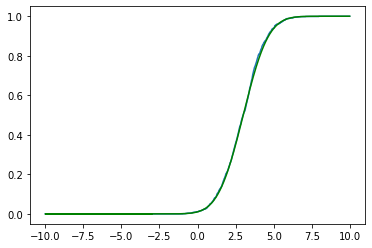

In [22]:
mu = 3
sigma = 1.3

steps, emp_dist = compute_empirical_dist(lambda:stats.norm.rvs(loc = mu, scale = sigma), 0.01, n_samples = 1000, rng = 10)

plt.plot(steps, emp_dist)
plt.plot(steps, [stats.norm.cdf(s, loc = mu, scale = sigma) for s in steps], 'g')
plt.show()

**Ejercicio.** Comprobar empíricamente el Teorema de Glivenko-Cantelli para la distribución $\chi^2$.

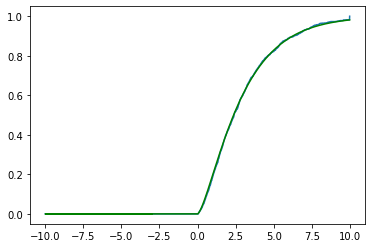

In [23]:
nu = 3

steps, emp_dist = compute_empirical_dist(lambda:stats.chi2.rvs(df = nu), 0.01, n_samples = 1000, rng = 10)

plt.plot(steps, emp_dist)
plt.plot(steps, [stats.chi2.cdf(s, df = nu) for s in steps], 'g')
plt.show()

**Ejercicio.** Comprobar empíricamente el Teorema de Glivenko-Cantelli para la distribución de Poisson.

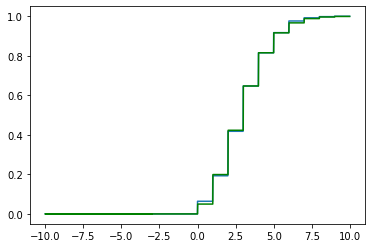

In [24]:
mu = 3

steps, emp_dist = compute_empirical_dist(lambda:stats.poisson.rvs(mu), 0.01, n_samples = 1000, rng = 10)

plt.plot(steps, emp_dist)
plt.plot(steps, [stats.poisson.cdf(s, mu) for s in steps], 'g')
plt.show()

**Ejercicio.** Calcular aproximadamente $k_{1-\alpha}$ para $\alpha = 0.1, 0.05$ y $0.01$.

**Observación.** Truncando la suma que define la función de distribución de $K$, podemos calcular una aproximación a la función de distribución como
$$
    \tilde{F}_K^N(x) = \frac{\sqrt{2\pi}}{x}\sum_{k=1}^N e^{-(2k-1)^2\pi^2/(8x^2)}.
$$
Estas aproximaciones se representan en la siguiente gráfica.

### 4.3.2. Test de Kolmogorov-Smirnov

El test de Kolmogorov-Smirnov, usualmente abreviado test KS, es uno de los test basados en el Teorema de Glivenko-Cantelli. Supongamos que $X_1, \ldots, X_n$ es una muestra aleatoria de variables independientes e idénticamente distribuidas. El test KS permite contrastar si conocemos la distribución de las variables $X_i$ **sin ningún tipo de asunción sobre su forma**. De este modo, sea $F$ la verdadera función de distribución de las variables $X_i$ y supongamos que nosotros queremos contrastar si la función de distribución es una cierta función $F_0$. De este modo, las hipótesis nula y alternativa son
$$
    H_0: F = F_0, \quad H_1: F \neq F_0.
$$

Para realizar este test, consideremos el estadístico
$$
    D_n = \sup_{x \in \mathbb{R}} |F_n(x) - F_0(x)|,
$$
donde $F_n(x)$ es la función de distribución empírica de la muestra $X_1, \ldots, X_n$. Por el Teorema de Glivenko-Cantelli, si $H_0$ es cierta, sabemos que $Q_n \to 0$ cuando $n \to 0$. La idea básica del test KS es que, de este modo, podemos contrastar $H_0$ comprobando si $Q_n$ es pequeño o no.

Sin embargo, el problema está en cuantificar cúanto de pequeño tiene que ser $Q_n$ para asegurar el test a nivel de significación $\alpha$. Para ello, necesitamos una extensión del Teorema de Glivenko-Cantelli que no solo diga que $Q_n \to 0$, sino además a qué ritmo lo hace. Ese resultado (no trivial) se conoce como Teorema de Kolmogorov.

**Teorema (Kolmogorov).** Consideremos la variable aleatoria de Kolmogorov $K$ cuya función de distribución es
$$
    F_K(x) = \mathbb{P}(K\leq x)=1-2\sum_{k=1}^\infty (-1)^{k-1} e^{-2k^2 x^2}=\frac{\sqrt{2\pi}}{x}\sum_{k=1}^\infty e^{-(2k-1)^2\pi^2/(8x^2)}.
$$
Si la función de distribución $F$ de la muestra $X_i$ es continua, entonces
$$
    \sqrt{n}D_n \stackrel{d}{\longrightarrow} K
$$
en distribución.

Con este teorema en la mano, ya tenemos la clave para formular el test KS. Obsérvese que la distribución de Kolmogorov $K$ no depende de $F$. De este modo, si $k_{1-\alpha}$ es el cuantil $1-\alpha$ de $K$, tenemos que
$$
    \mathbb{P}(K \leq k_{1-\alpha}) = 1 - \alpha. 
$$
De este modo, para $n$ suficientemente grande, tenemos que
$$
    \mathbb{P}(\sqrt{n}D_n \leq k_{1-\alpha}) = \mathbb{P}\left(\sqrt{n}\sup_{x \in \mathbb{R}} |F_n(x) - F_0(x)| \leq k_{1-\alpha}\right) \approx 1 - \alpha.
$$
Esto nos proporciona un test tomando $Q_n = \sqrt{n}D_n$ e $I_\alpha = (-\infty, k_{1-\alpha}$. El criterio de este test es, pues
- Aceptamos $H_0$ si
$$
    \sup_{x \in \mathbb{R}} |F_n(x) - F_0(x)| \leq k_{1-\alpha}.
$$
- Rechazamos $H_0$ (aceptamos $H_1$) si
$$
\sup_{x \in \mathbb{R}} |F_n(x) - F_0(x)| > k_{1-\alpha}.
$$

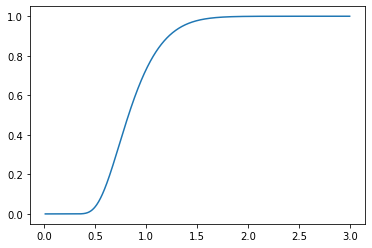

In [25]:
def approx_kolmogorov_dist(N, x):
    return 1-2*sum([(-1)**(k-1)*np.exp(-2*k**2*x**2) for k in range(1, N + 1)])

approx_kolmogorov_dist_vect = np.vectorize(lambda x :approx_kolmogorov_dist(1000, x))

x = np.linspace(0.01, 3, 1000)
y = approx_kolmogorov_dist_vect(x)

plt.plot(x, y)
plt.show()

**Ejercicio.** Comprobar empíricamente el Teorema de Kolmogorov-Smirnov para dos muestras.

**Ejercicio 2.** Generar dos muestras de tamaño 1000 de dos normales, de desviaciones típicas $1.3$ y $1.4$. Compararlas con un test de Kolmogorov-Smirnov para dos muestras y calcular su $p$-valor.